# HuggingFace: Zero Shot Image Classification

## Imports

In [1]:
import datasets
import pandas as pd
import numpy as np
from transformers import pipeline
from PIL import Image
import matplotlib.pyplot as plt

/Users/mocha/miniconda3/envs/mamba/envs/fastai_env/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In this section, I will be attempting zero-shot classification (image detection with really good accuracy!) of the Fashion MNIST image dataset as in the previous section Fast-AI/fast_ai_vision. However, in this section I hope to improve on the results and learn on the errors that were made in the previous notebook. In my previous first attempt, I attempted to create my own dataloader using my own "dsets"/tuples of numpy lists containing images (PIL.Image objects) and numeric labels, and then passing it to fastAI "ImageDataLoaders.from_dsets". 

I also attempted to build my own custom model using PyTorch and then feed in the batched images using the dataloader to train the PyTorch model. This had been a mistake as the dataloader I created did not format the data in a way that aligned with the input for the model. 

In this notebook, I will be automating that process by using a pre-trained HuggingFace image detector - skipping the need to train the model. I will then run inference on a sample the fashion-mnist images. 

I hope to see accurate results given this is a zero-shot image classifier with zero fine-tuning!

## Loading the Data

In [2]:
fashion_mnist = datasets.load_dataset("fashion_mnist", cache_dir='../../data/image_data')

Found cached dataset fashion_mnist (/Users/mocha/DataspellProjects/CMPE258/FastAI-Keras/HuggingFace/Vision-Model/../../data/image_data/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
fashion_mnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [4]:
fashion_testx, fashion_testy = fashion_mnist['test']['image'], fashion_mnist['test']['label']

In [5]:
clothing_labels = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

In [6]:
fashion_testy_article = [clothing_labels[article_index] for article_index in fashion_testy]

In [7]:
fashion_test = pd.DataFrame({'image':fashion_testx, 'label': fashion_testy_article})
fashion_test.head()

,image,label
0,<PIL.PngImagePlugin.PngImageFile image mode=L ...,Ankle boot
1,<PIL.PngImagePlugin.PngImageFile image mode=L ...,Pullover
2,<PIL.PngImagePlugin.PngImageFile image mode=L ...,Trouser
3,<PIL.PngImagePlugin.PngImageFile image mode=L ...,Trouser
4,<PIL.PngImagePlugin.PngImageFile image mode=L ...,Shirt


In [8]:
fashion_test_sample = fashion_test.sample(10)
fashion_test_sample.reset_index(inplace=True, drop=True)

## Zero shot classification

In [9]:
checkpoint = "openai/clip-vit-large-patch14"
zeroshot_detector = pipeline(model=checkpoint, task="zero-shot-image-classification")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/Users/mocha/miniconda3/envs/mamba/envs/fastai_env/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_

In [10]:
def apply_zs_image_classifier(column, pipeline=zeroshot_detector, candidate_labels=list(clothing_labels.values())):
    output = {'image': [], 'predicted_label':[], 'score':[]}
    def map_to_input(row, input_map = output):
        results = pipeline(row,  candidate_labels=candidate_labels)
        input_map['image'].append(row)
        max_score = float('-inf')  # Initialize max score to negative infinity
        max_score_label = None # we will only select the label with the max score
        for label in results:
            if label['score'] > max_score:
                max_score = label['score']
                max_score_label = label
        if max_score_label is not None:
            input_map['predicted_label'].append(max_score_label['label'])
            input_map['score'].append(max_score_label['score'])
        else:
            input_map['predicted_label'].append(np.nan)
            input_map['score'].append(np.nan)
    column.apply(map_to_input)
    return output

In [11]:
zs_fashion_labels = pd.DataFrame(apply_zs_image_classifier(fashion_test_sample['image']))

In [12]:
zs_fashion_labels.head()

,image,predicted_label,score
0,<PIL.PngImagePlugin.PngImageFile image mode=L ...,Ankle boot,0.994551
1,<PIL.PngImagePlugin.PngImageFile image mode=L ...,Dress,0.509533
2,<PIL.PngImagePlugin.PngImageFile image mode=L ...,T-shirt/top,0.502580
3,<PIL.PngImagePlugin.PngImageFile image mode=L ...,Dress,0.375539
4,<PIL.PngImagePlugin.PngImageFile image mode=L ...,Ankle boot,0.993877


In [13]:
fashion_test_sample.head()

,image,label
0,<PIL.PngImagePlugin.PngImageFile image mode=L ...,Ankle boot
1,<PIL.PngImagePlugin.PngImageFile image mode=L ...,Pullover
2,<PIL.PngImagePlugin.PngImageFile image mode=L ...,Shirt
3,<PIL.PngImagePlugin.PngImageFile image mode=L ...,Pullover
4,<PIL.PngImagePlugin.PngImageFile image mode=L ...,Ankle boot


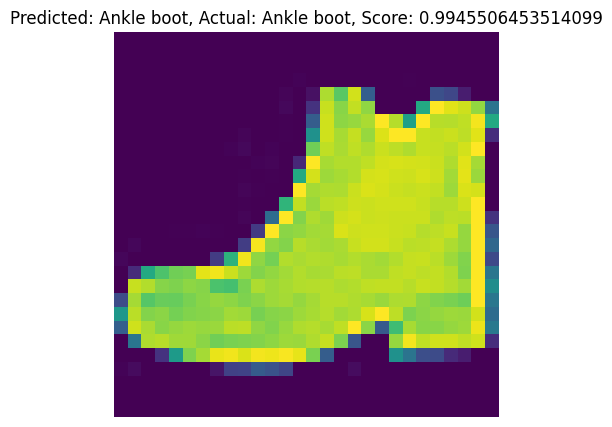

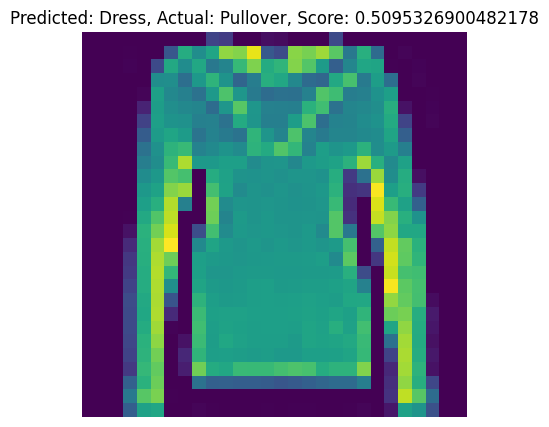

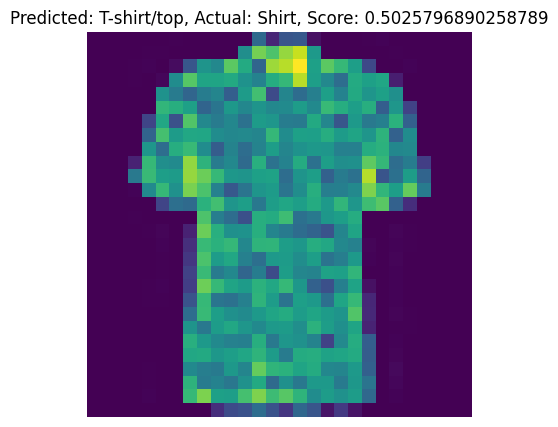

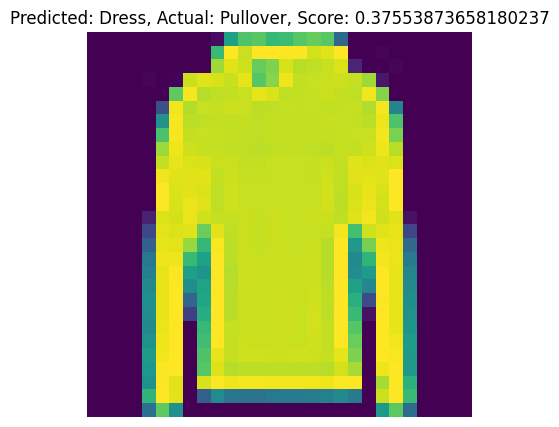

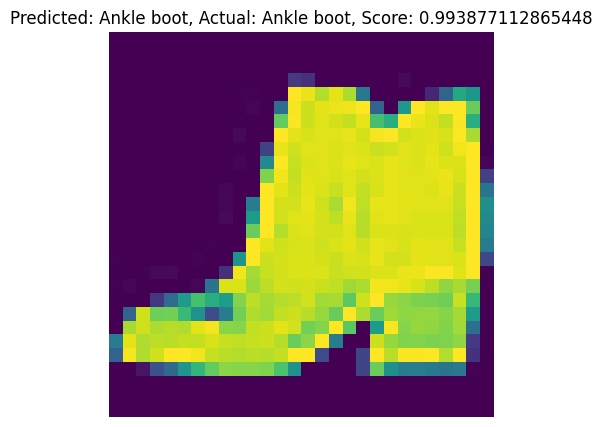

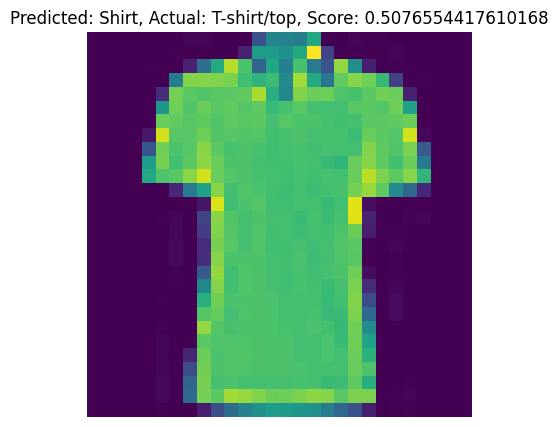

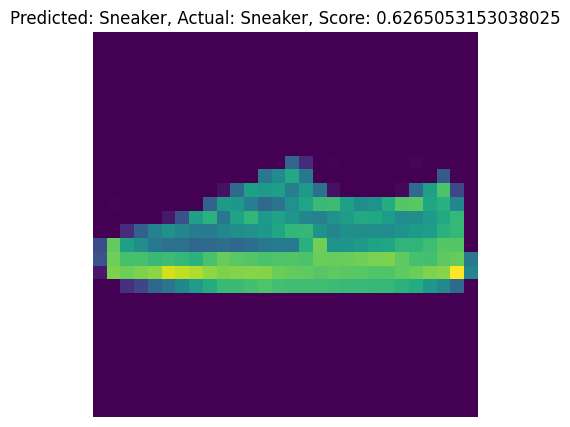

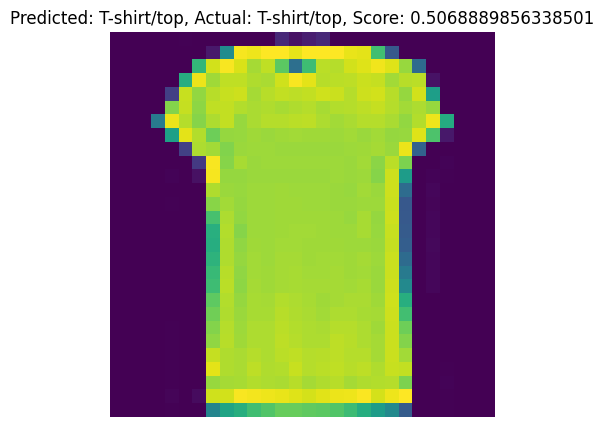

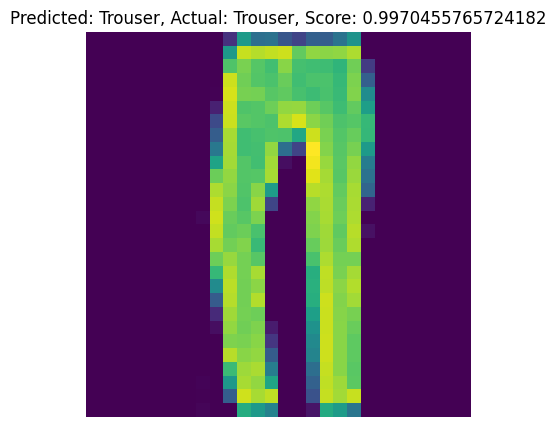

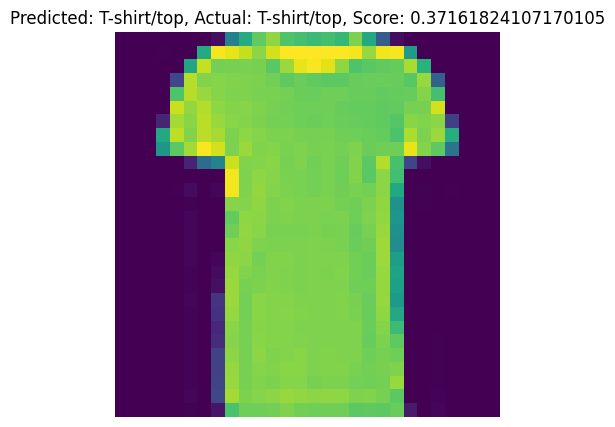

In [14]:
for i in range(len(zs_fashion_labels)):
    example_fashion_pred_label = zs_fashion_labels.loc[i,'predicted_label']
    example_fashion_pred_score = zs_fashion_labels.loc[i,'score']
    example_fashion_label = fashion_test_sample.iloc[i]['label']
    # Display the image with a larger size
    plt.figure(figsize=(5, 5))  # Adjust the figsize as needed
    plt.imshow(fashion_test_sample.loc[i,'image'])
    plt.title(f'Predicted: {example_fashion_pred_label}, Actual: {example_fashion_label}, Score: {example_fashion_pred_score}')
    plt.axis('off')  # Turn off axis
    plt.show()

## Conclusion

The performance of this model on the test sample of 10 images seems to be variable. As there are 10 classes, this model has the opportunity to make a lot of mistakes between classes with similar features. For example, ankle boot & sandle, coat & shirt, etc. The model is also slower than the text generation models as it is working with more highly dimensional images. Inferring on many more images in a big data setting would require more compute but would allow for further evaluating the models performance as that requires more data points. 

I enjoyed experimenting with pre-trained huggingface models as many are open-source and can be improved with further fine-tuning. 